In [4]:
# Install dependencies
!pip install -q transformers==4.17
!pip install tensorflow==2.15.0 --quiet
!pip install tf_keras==2.15.0 --quiet
!pip install keras==2.15.0 --quiet
!pip install tensorflow-text==2.15.0 --quiet

In [5]:
# import libraries/modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import cmudict

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, LSTM, Input, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras import Model
from transformers import TFBertModel, BertTokenizer, AutoTokenizer, TFAutoModel, AutoConfig

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_fscore_support, classification_report as sk_classification_report

In [6]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# load dataset
np.random.seed(42)
poems_df = pd.read_csv('/content/drive/MyDrive/poems_clean.csv')
poems_df = poems_df.sample(frac=1)
FORM_CLASSES = poems_df['form'].unique()

In [8]:
# Label encode forms
# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform the column
poems_df['forms_encoded'] = le.fit_transform(poems_df['form'])

# Split data into training, validation, and test sets
x_train, x_val, y_train, y_val = train_test_split(poems_df['poem_text'], poems_df['forms_encoded'], test_size=0.40, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(poems_df['poem_text'], poems_df['forms_encoded'], test_size=0.50, random_state=1234)

# apply one-hot encoding to labels
y_train_one_hot = tf.one_hot(y_train, depth=9)
y_val_one_hot = tf.one_hot(y_val, depth=9)
y_test_one_hot = tf.one_hot(y_test, depth=9)

In [9]:
# compute class weights
def compute_class_weights(labels):
    # Calculate class weights to correct for class imbalance
    weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    label_weights = dict(enumerate(weights))

    return label_weights

CLASS_WEIGHTS = compute_class_weights(y_train_one_hot.numpy().argmax(axis=1))
print(CLASS_WEIGHTS)

{0: 1.1822916666666667, 1: 2.802469135802469, 2: 1.2824858757062148, 3: 1.7596899224806202, 4: 2.480874316939891, 5: 1.0966183574879227, 6: 2.292929292929293, 7: 0.24849480021893816, 8: 1.4836601307189543}


In [10]:
# Set max length
MAX_LENGTH = 512

# Create bert encoder function
def bert_encode(texts, tokenizer, max_len=MAX_LENGTH, min_word_freq=3):
    # Convert texts to strings
    texts_str = [str(text) for text in texts]

    # Count word frequencies
    word_freq = {}
    for text in texts_str:
        for word in text.split():
            word_freq[word] = word_freq.get(word, 0) + 1

    # Filter rare words
    filtered_texts = []
    for text in texts_str:
        words = text.split()
        filtered_words = [word if word_freq[word] >= min_word_freq else '[UNK]' for word in words]
        filtered_texts.append(' '.join(filtered_words))

    # Tokenize filtered texts
    tokenized = tokenizer(filtered_texts,
                         max_length=max_len,
                         truncation=True,
                         padding='max_length',
                         return_tensors='tf')

    return tokenized

# select tokenizer
def select_tokenizer(pretrained):
    tokenizers = {
        'bert-base-cased': BertTokenizer.from_pretrained(pretrained),
        'linhd-postdata/alberti-bert-base-multilingual-cased': AutoTokenizer.from_pretrained(pretrained)
    }
    tokenizer = tokenizers[pretrained]
    return tokenizer


Baseline Model

In [11]:
# Baseline model build function
def build_baseline_model(bert_base,
                         trainable=True,
                         max_length=MAX_LENGTH,
                         num_classes=len(FORM_CLASSES),
                         hidden_size=256,
                         dropout=0.3,
                         learning_rate=0.00005,
                         optimizer='adam'):

    bert_model = TFBertModel.from_pretrained(bert_base)
    bert_model.trainable = trainable

    input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_output = bert_model(bert_inputs)
    pooler_output = bert_output[1]
    hidden = Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_output)
    dropout_layer = Dropout(dropout)(hidden)
    class_output = Dense(num_classes, activation='softmax', name="classification_layer")(dropout_layer)

    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=class_output)

    if optimizer == 'adam':
      optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'adamw':
      optimizer = AdamW(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model


# Select pretrained
model_checkpoint = 'bert-base-cased'

# Load tokenizer
bert_tokenizer = select_tokenizer(model_checkpoint)

# Tokenize dataset
train_encodings = bert_encode(x_train, bert_tokenizer)
train_labels = np.array(y_train_one_hot)
val_encodings = bert_encode(x_val, bert_tokenizer)
val_labels = np.array(y_val_one_hot)
test_encodings = bert_encode(x_test, bert_tokenizer)
test_labels = np.array(y_test_one_hot)

# Obtain instance of pretrained model
baseline_model = build_baseline_model(model_checkpoint)
baseline_model.summary()

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                      

In [12]:
# Train model
baseline_history = baseline_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                      train_labels,
                                      validation_data=([val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask], val_labels),
                                      batch_size=8,
                                      epochs=1,
                                      class_weight=CLASS_WEIGHTS)

171/171 [==============================] - 96s 332ms/step - loss: 2.2182 - accuracy: 0.1887 - precision: 0.1154 - recall: 0.0022 - val_loss: 2.0658 - val_accuracy: 0.1022 - val_precision: 0.4444 - val_recall: 0.0035


In [13]:
baseline_score = baseline_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask],
                                test_labels)

print('Test loss:', baseline_score[0])
print('Test accuracy:', baseline_score[1])

36/36 [==============================] - 9s 263ms/step - loss: 2.0836 - accuracy: 0.0872 - precision: 0.6364 - recall: 0.0062
Test loss: 2.083556652069092
Test accuracy: 0.08722466975450516


36/36 [==============================] - 12s 259ms/step


<Axes: >

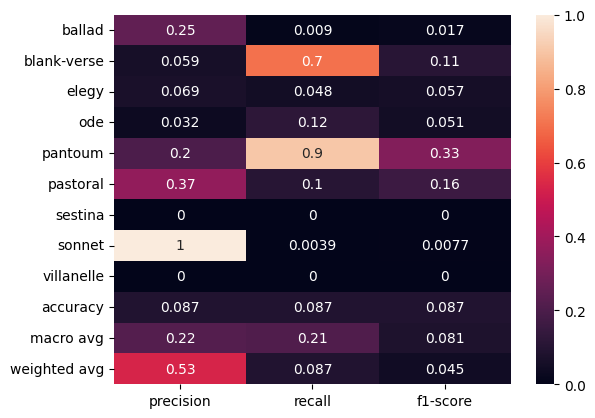

In [14]:
predictions = baseline_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
baseline_model_preds = tf.argmax(predictions, axis=-1)
class_report = sk_classification_report(y_test, baseline_model_preds.numpy(), zero_division=0, target_names=le.classes_, output_dict=True)
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True)

Text(220.72222222222223, 0.5, 'True')

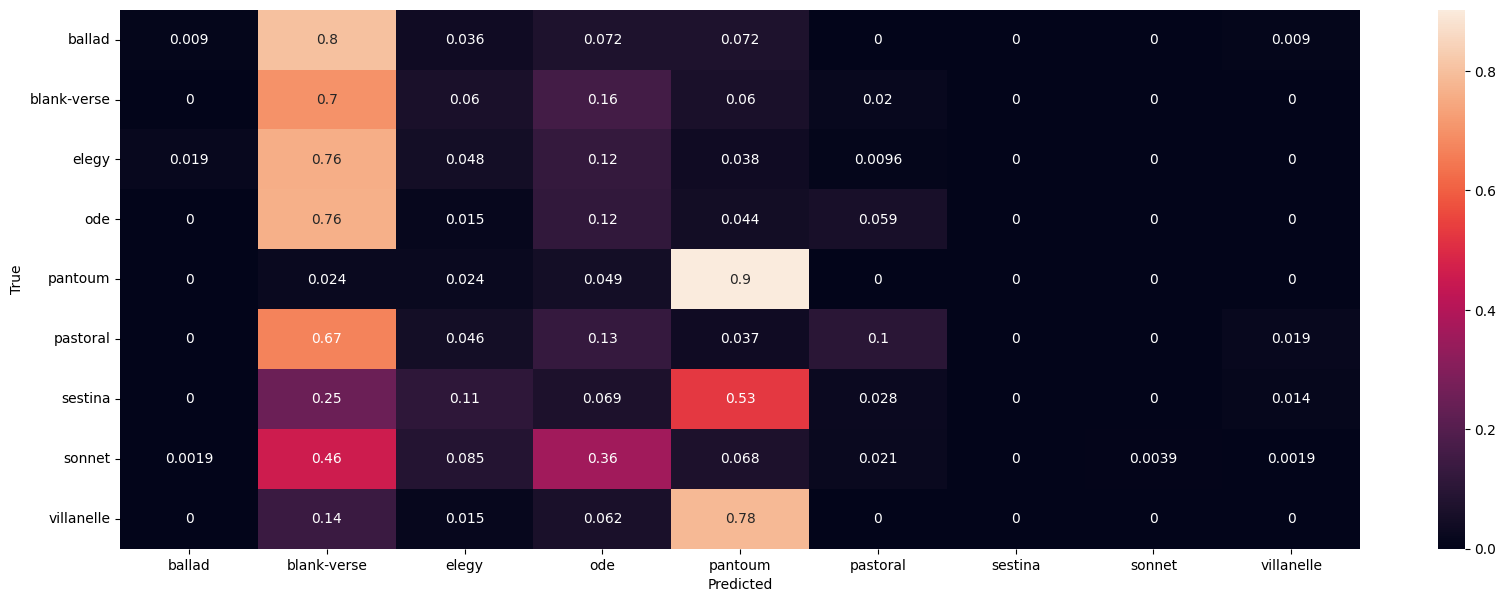

In [15]:
# Create confusion matrix
conf_matrix = tf.math.confusion_matrix(y_test, baseline_model_preds)
conf_matrix = conf_matrix/conf_matrix.numpy().sum(axis=1)[:, tf.newaxis]

# Visualize confusion matrix
plt.figure(figsize=(20,7))
sns.heatmap(
    conf_matrix, annot=True,
    xticklabels=le.classes_,
    yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")

BERT + BiLSTM (no syllable features)

In [16]:
def build_bertLSTM_model(bert_base,
                         trainable=True,
                         max_length=MAX_LENGTH,
                         num_classes=len(FORM_CLASSES),
                         hidden_size=256,
                         dropout=0.3,
                         learning_rate=0.00005,
                         optimizer='adam'):

    bert_model = TFBertModel.from_pretrained(bert_base)
    bert_model.trainable = trainable

    input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_output = bert_model(bert_inputs)
    sequence_output = bert_output[0] # Sequence output instead of pooler output

    lstm_layer = LSTM(hidden_size)(sequence_output)

    dropout_layer = Dropout(dropout)(lstm_layer)

    hidden = Dense(hidden_size, activation='relu', name='hidden_layer')(dropout_layer)

    dropout_layer = Dropout(dropout)(hidden)

    class_output = Dense(num_classes, activation='softmax', name="classification_layer")(dropout_layer)

    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=class_output)

    if optimizer == 'adam':
      optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'adamw':
      optimizer = AdamW(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model


# Select pretrained
model_checkpoint = 'bert-base-cased'

# Obtain instance of pretrained model
bertLSTM_model = build_bertLSTM_model(model_checkpoint)
bertLSTM_model.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                    

In [17]:
# Train model
bertLSTM_model_history = bertLSTM_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                      train_labels,
                                      validation_data=([val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask], val_labels),
                                      batch_size=8,
                                      epochs=1,
                                      class_weight=CLASS_WEIGHTS)

171/171 [==============================] - 99s 354ms/step - loss: 2.1594 - accuracy: 0.2085 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 2.0748 - val_accuracy: 0.1419 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00


In [18]:
score = bertLSTM_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask],
                                test_labels)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

36/36 [==============================] - 10s 270ms/step - loss: 2.0883 - accuracy: 0.1048 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Test loss: 2.088275194168091
Test accuracy: 0.1048458144068718


36/36 [==============================] - 13s 268ms/step


<Axes: >

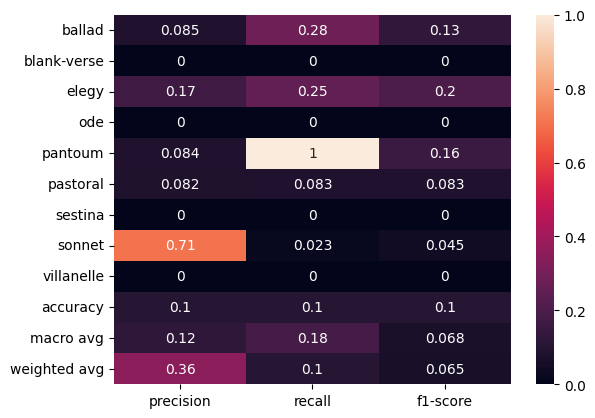

In [19]:
predictions = bertLSTM_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
bertLSTM_model_preds = tf.argmax(predictions, axis=-1)
class_report = sk_classification_report(y_test, bertLSTM_model_preds.numpy(), zero_division=0, target_names=le.classes_, output_dict=True)
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True)

Text(220.72222222222223, 0.5, 'True')

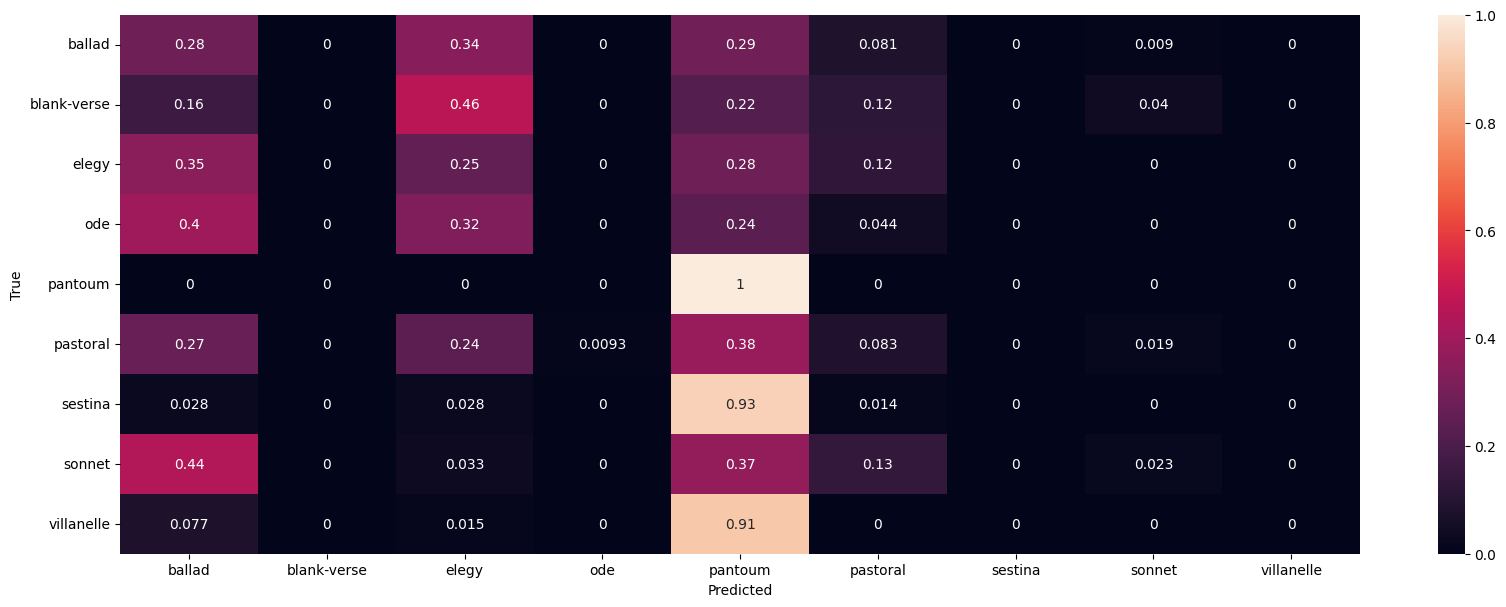

In [20]:
# Create confusion matrix
conf_matrix = tf.math.confusion_matrix(y_test, bertLSTM_model_preds)
conf_matrix = conf_matrix/conf_matrix.numpy().sum(axis=1)[:, tf.newaxis]

# Visualize confusion matrix
plt.figure(figsize=(20,7))
sns.heatmap(
    conf_matrix, annot=True,
    xticklabels=le.classes_,
    yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")

## BERT + BiLSTM + syllable features

In [21]:
nltk.download('cmudict')
# Initialize CMU dictionary
prondict = cmudict.dict()

def get_syllable_features(text, max_length, prondict):
    words = text.split()
    syllable_counts = []
    for word in words:
        try:
            # Get number of syllables from CMU dict
            count = [len(list(y for y in x if y[-1].isdigit())) for x in prondict[word.lower()]][0]
        except:
            count = 1  # Default for unknown words
        syllable_counts.append(count)

    # Pad sequence to max_length
    return np.array(syllable_counts + [0] * (max_length - len(syllable_counts)))[:max_length]

def build_bertLSTM_model2(bert_base,
                         trainable=True,
                         max_length=MAX_LENGTH,
                         num_classes=len(FORM_CLASSES),
                         hidden_size=256,
                         dropout=0.3,
                         learning_rate=0.00005,
                         optimizer='adam'):


    # BERT inputs
    input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')

    # Syllable input
    syllable_input = Input(shape=(max_length,), dtype=tf.float16, name='syllable_features')

    # BERT processing
    bert_model = TFBertModel.from_pretrained(bert_base)
    bert_model.trainable = trainable
    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}
    bert_output = bert_model(bert_inputs)
    sequence_output = bert_output[0]

    # Combine BERT output with syllable features
    combined_features = Concatenate(axis=-1)([sequence_output,
                                            tf.expand_dims(syllable_input, -1)])

    # BiLSTM processing
    bilstm_layer = Bidirectional(LSTM(hidden_size))(combined_features)
    dropout_layer = Dropout(dropout)(bilstm_layer)
    class_output = Dense(num_classes, activation='softmax', name="classification_layer")(dropout_layer)

    if optimizer == 'adam':
      optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'adamw':
      optimizer = AdamW(learning_rate=learning_rate)

    model = Model(inputs=[input_ids, token_type_ids, attention_mask, syllable_input],
                 outputs=class_output)
    model.compile(Adam(learning_rate=learning_rate),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model


# Select pretrained
model_checkpoint = 'bert-base-cased'

# Obtain instance of pretrained model
bertLSTM_model2 = build_bertLSTM_model2(model_checkpoint)
bertLSTM_model2.summary()


[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.
Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                    

In [22]:
syllable_features_train = np.array([get_syllable_features(text, MAX_LENGTH, cmudict.dict()) for text in x_train])
syllable_features_val = np.array([get_syllable_features(text, MAX_LENGTH, cmudict.dict()) for text in x_val])
syllable_features_test = np.array([get_syllable_features(text, MAX_LENGTH, cmudict.dict()) for text in x_test])

In [23]:
# Fit model
bertLSTM_model2_history = bertLSTM_model2.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask, syllable_features_train],
                                      train_labels,
                                      validation_data=([val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask, syllable_features_val], val_labels),
                                      batch_size=8,
                                      epochs=1,
                                      class_weight=CLASS_WEIGHTS)

171/171 [==============================] - 104s 378ms/step - loss: 2.1189 - accuracy: 0.2878 - precision_2: 0.4821 - recall_2: 0.0198 - val_loss: 1.7803 - val_accuracy: 0.3762 - val_precision_2: 0.5000 - val_recall_2: 0.0018


In [24]:
score = bertLSTM_model2.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask, syllable_features_test],
                                test_labels)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

36/36 [==============================] - 10s 278ms/step - loss: 1.7526 - accuracy: 0.3674 - precision_2: 0.8333 - recall_2: 0.0044
Test loss: 1.752638578414917
Test accuracy: 0.3674008846282959


36/36 [==============================] - 13s 274ms/step


<Axes: >

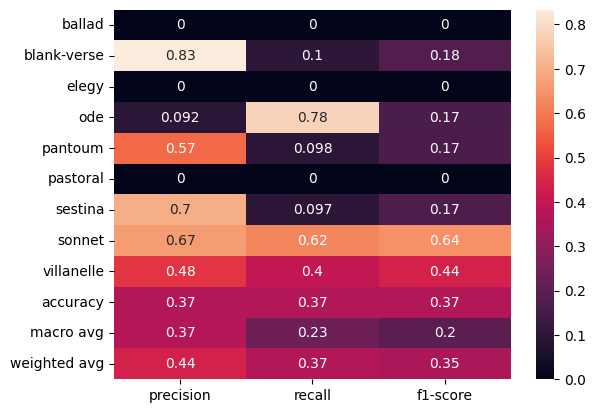

In [25]:
predictions = bertLSTM_model2.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask, syllable_features_test])
bertLSTM_model2_preds = tf.argmax(predictions, axis=-1)
class_report = sk_classification_report(y_test, bertLSTM_model2_preds.numpy(), zero_division=0, target_names=le.classes_, output_dict=True)
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True)

Text(220.72222222222223, 0.5, 'True')

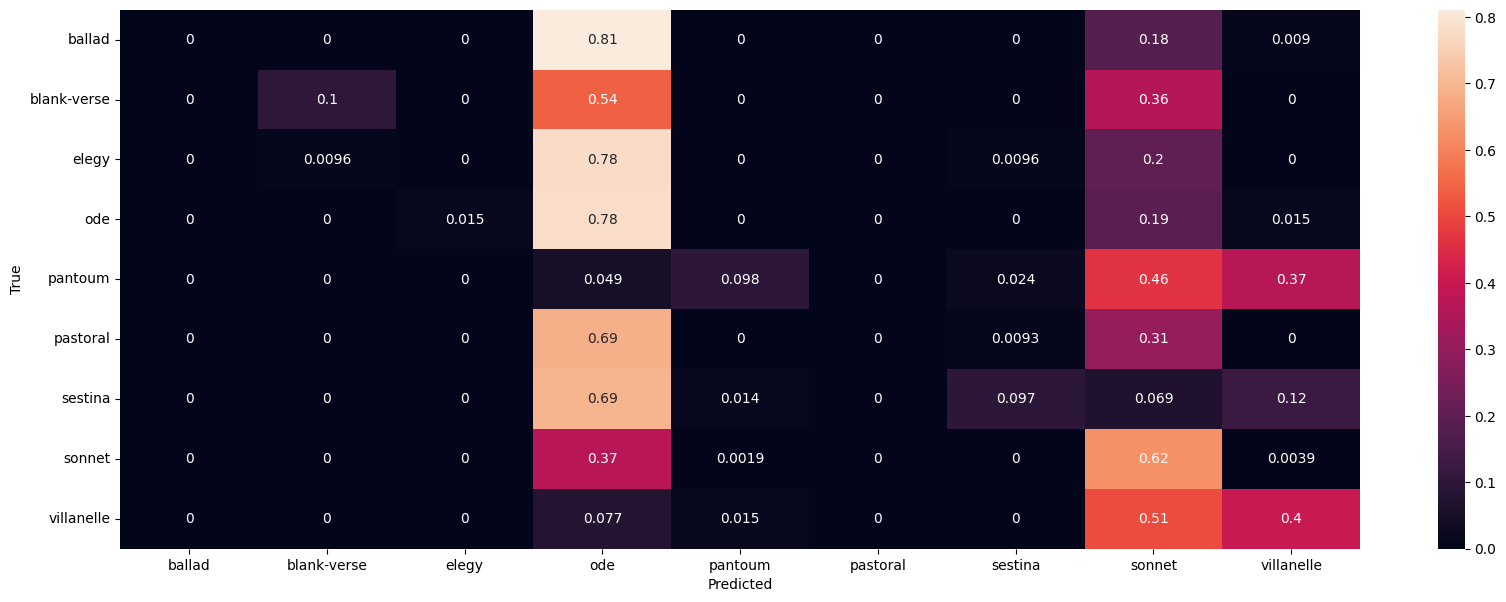

In [26]:
# Create confusion matrix
conf_matrix = tf.math.confusion_matrix(y_test, bertLSTM_model2_preds)
conf_matrix = conf_matrix/conf_matrix.numpy().sum(axis=1)[:, tf.newaxis]

# Visualize confusion matrix
plt.figure(figsize=(20,7))
sns.heatmap(
    conf_matrix, annot=True,
    xticklabels=le.classes_,
    yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")

### Increase number of epochs

Epoch 1/3
171/171 [==============================] - 60s 350ms/step - loss: 1.6937 - accuracy: 0.4677 - precision_2: 0.7341 - recall_2: 0.1439 - val_loss: 1.2772 - val_accuracy: 0.6608 - val_precision_2: 0.8953 - val_recall_2: 0.1507
Epoch 2/3
171/171 [==============================] - 58s 342ms/step - loss: 1.2825 - accuracy: 0.6050 - precision_2: 0.7902 - recall_2: 0.3678 - val_loss: 0.9914 - val_accuracy: 0.7163 - val_precision_2: 0.8798 - val_recall_2: 0.5225
Epoch 3/3
36/36 [==============================] - 10s 274ms/step


Text(220.72222222222223, 0.5, 'True')

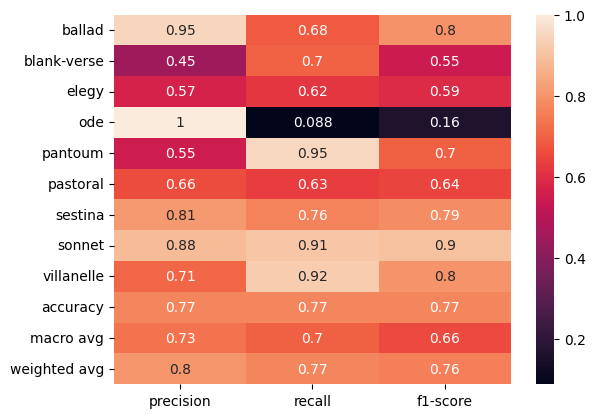

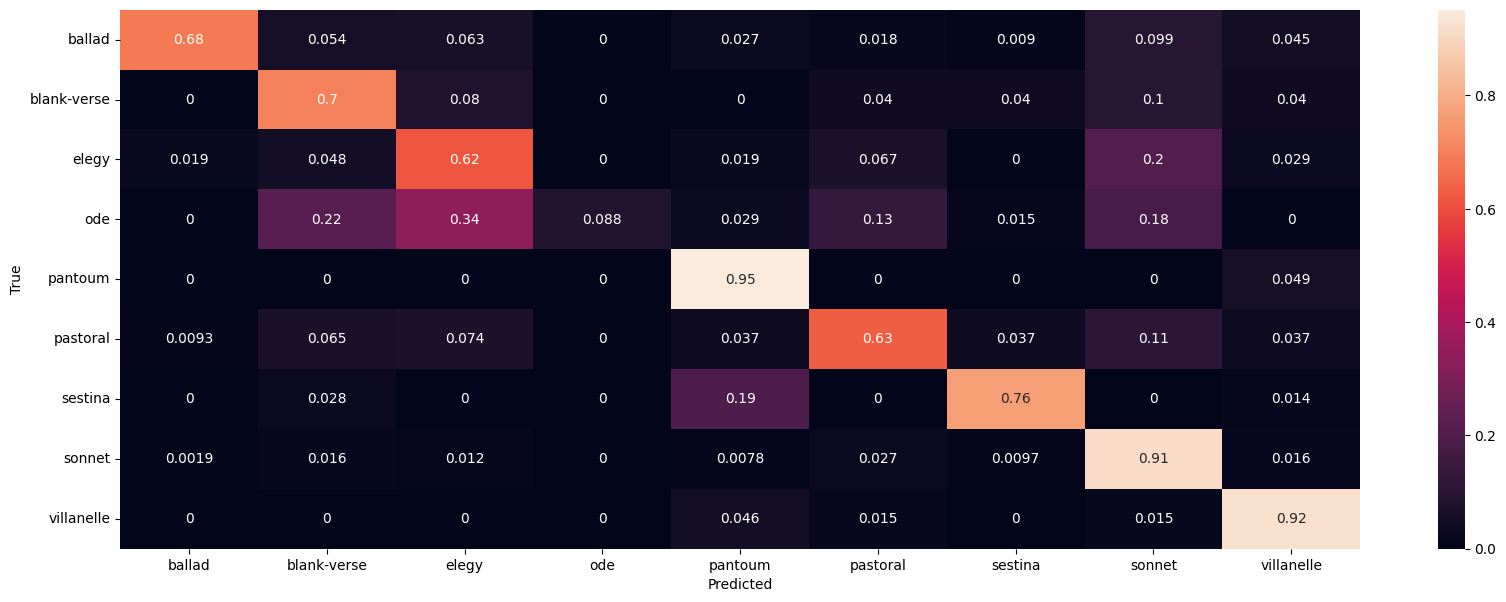

In [27]:
bertLSTM_model2_history = bertLSTM_model2.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask, syllable_features_train],
                                      train_labels,
                                      validation_data=([val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask, syllable_features_val], val_labels),
                                      batch_size=8,
                                      epochs=3,
                                      class_weight=CLASS_WEIGHTS)

predictions = bertLSTM_model2.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask, syllable_features_test])
bertLSTM_model2_preds = tf.argmax(predictions, axis=-1)
class_report = sk_classification_report(y_test, bertLSTM_model2_preds.numpy(), zero_division=0, target_names=le.classes_, output_dict=True)
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True)

# Create confusion matrix
conf_matrix = tf.math.confusion_matrix(y_test, bertLSTM_model2_preds)
conf_matrix = conf_matrix/conf_matrix.numpy().sum(axis=1)[:, tf.newaxis]

# Visualize confusion matrix
plt.figure(figsize=(20,7))
sns.heatmap(
    conf_matrix, annot=True,
    xticklabels=le.classes_,
    yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")

### Test learning rate

Learning rate: 0.0001


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3


171/171 [==============================] - 104s 377ms/step - loss: 2.2441 - accuracy: 0.2673 - precision_3: 0.7248 - recall_3: 0.0580 - val_loss: 2.5098 - val_accuracy: 0.0405 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/3
171/171 [==============================] - 60s 351ms/step - loss: 2.3281 - accuracy: 0.1013 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 2.1854 - val_accuracy: 0.1119 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/3
36/36 [==============================] - 13s 273ms/step


<Axes: >

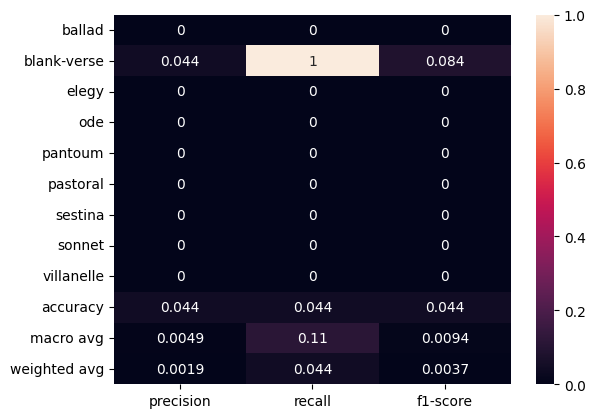

In [28]:
print("Learning rate: 0.0001")
bertLSTM_model2 = build_bertLSTM_model2(model_checkpoint, learning_rate=0.0001)
bertLSTM_model2_history = bertLSTM_model2.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask, syllable_features_train],
                                      train_labels,
                                      validation_data=([val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask, syllable_features_val], val_labels),
                                      batch_size=8,
                                      epochs=3,
                                      class_weight=CLASS_WEIGHTS)
predictions = bertLSTM_model2.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask, syllable_features_test])
bertLSTM_model2_preds = tf.argmax(predictions, axis=-1)
class_report = sk_classification_report(y_test, bertLSTM_model2_preds.numpy(), zero_division=0, target_names=le.classes_, output_dict=True)
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True)




Learning rate: 0.00025


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3


171/171 [==============================] - 104s 380ms/step - loss: 1.8410 - accuracy: 0.3877 - precision_4: 0.7412 - recall_4: 0.0463 - val_loss: 1.2387 - val_accuracy: 0.6326 - val_precision_4: 0.8875 - val_recall_4: 0.3824
Epoch 2/3
171/171 [==============================] - 60s 351ms/step - loss: 1.2583 - accuracy: 0.5925 - precision_4: 0.8258 - recall_4: 0.2959 - val_loss: 1.0068 - val_accuracy: 0.6837 - val_precision_4: 0.8609 - val_recall_4: 0.4855
Epoch 3/3
36/36 [==============================] - 13s 274ms/step


<Axes: >

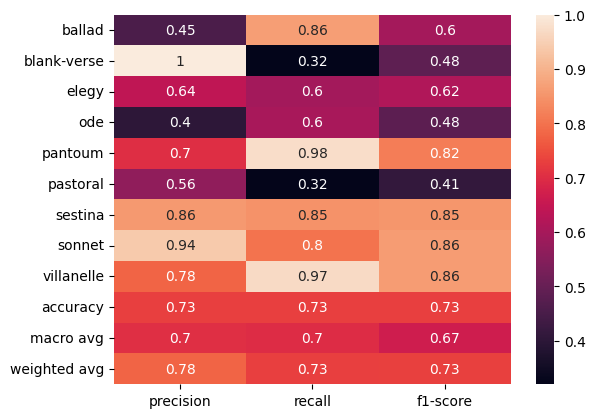

In [29]:
print("\nLearning rate: 0.00025")
bertLSTM_model2 = build_bertLSTM_model2(model_checkpoint, learning_rate=0.000025)
bertLSTM_model2_history = bertLSTM_model2.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask, syllable_features_train],
                                      train_labels,
                                      validation_data=([val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask, syllable_features_val], val_labels),
                                      batch_size=8,
                                      epochs=3,
                                      class_weight=CLASS_WEIGHTS)
predictions = bertLSTM_model2.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask, syllable_features_test])
bertLSTM_model2_preds = tf.argmax(predictions, axis=-1)
class_report = sk_classification_report(y_test, bertLSTM_model2_preds.numpy(), zero_division=0, target_names=le.classes_, output_dict=True)
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True)

### Increase batch size and number of epochs


Final model


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                    

86/86 [==============================] - 93s 629ms/step - loss: 1.9704 - accuracy: 0.2606 - precision_5: 0.5688 - recall_5: 0.0455 - val_loss: 1.4783 - val_accuracy: 0.4960 - val_precision_5: 0.6667 - val_recall_5: 0.0722
Epoch 2/5
86/86 [==============================] - 50s 585ms/step - loss: 1.3582 - accuracy: 0.5330 - precision_5: 0.8094 - recall_5: 0.2651 - val_loss: 1.1749 - val_accuracy: 0.6238 - val_precision_5: 0.8464 - val_recall_5: 0.4176
Epoch 3/5
86/86 [==============================] - 50s 585ms/step - loss: 0.9878 - accuracy: 0.6865 - precision_5: 0.8537 - recall_5: 0.4927 - val_loss: 0.8739 - val_accuracy: 0.7551 - val_precision_5: 0.9169 - val_recall_5: 0.5542
Epoch 4/5
86/86 [==============================] - 50s 585ms/step - loss: 0.6201 - accuracy: 0.8040 - precision_5: 0.8931 - recall_5: 0.6990 - val_loss: 0.9050 - val_accuracy: 0.7137 - val_precision_5: 0.8113 - val_recall_5: 0.6097
Epoch 5/5
36/36 [==============================] - 13s 274ms/step


<Axes: >

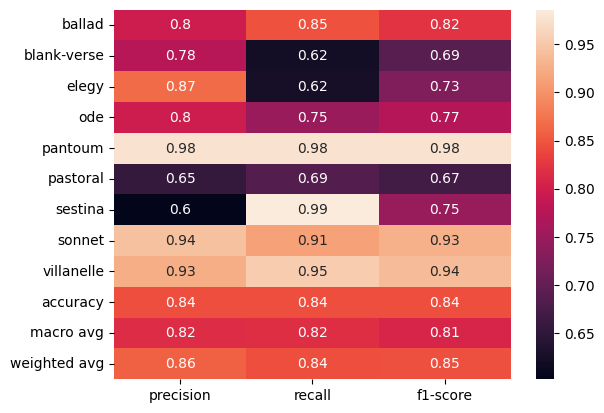

In [30]:
print("\nFinal model")
bertLSTM_model2 = build_bertLSTM_model2(model_checkpoint, learning_rate=0.00005)
bertLSTM_model2.summary()
bertLSTM_model2_history = bertLSTM_model2.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask, syllable_features_train],
                                      train_labels,
                                      validation_data=([val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask, syllable_features_val], val_labels),
                                      batch_size=16,
                                      epochs=5,
                                      class_weight=CLASS_WEIGHTS)


predictions = bertLSTM_model2.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask, syllable_features_test])
bertLSTM_model2_preds = tf.argmax(predictions, axis=-1)
class_report = sk_classification_report(y_test, bertLSTM_model2_preds.numpy(), zero_division=0, target_names=le.classes_, output_dict=True)
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True)


Text(220.72222222222223, 0.5, 'True')

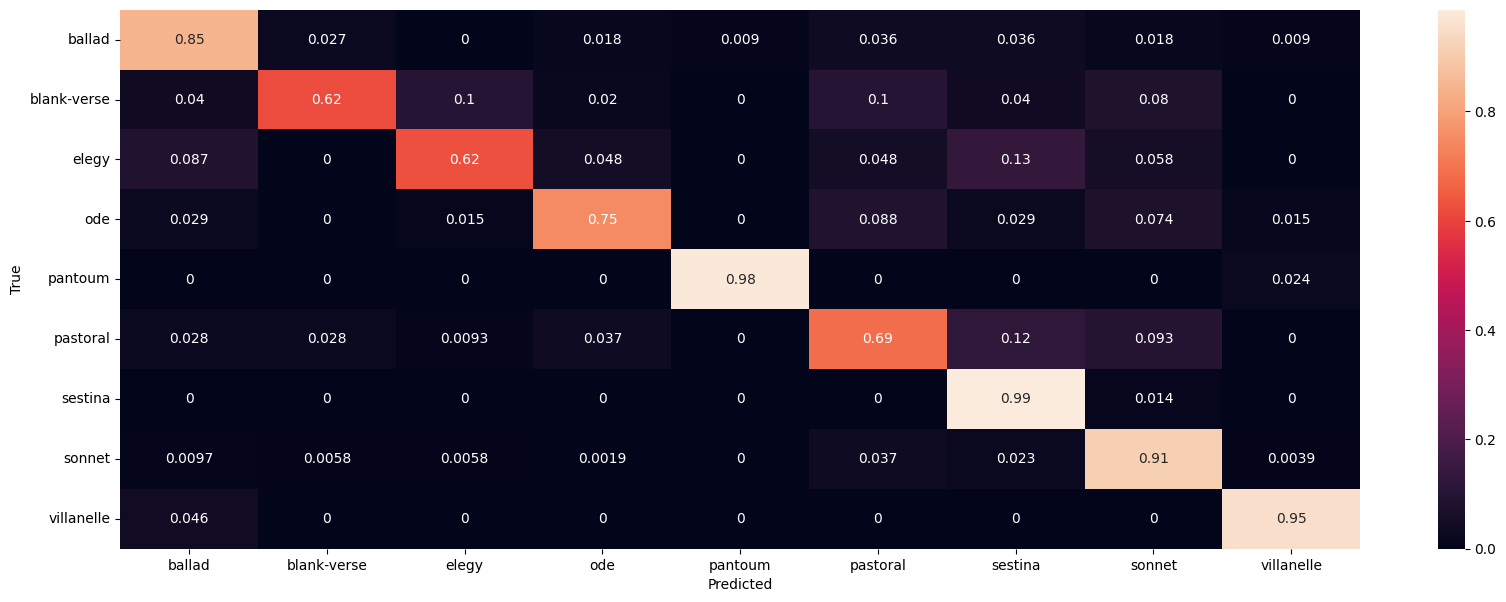

In [31]:
# Create confusion matrix
conf_matrix = tf.math.confusion_matrix(y_test, bertLSTM_model2_preds)
conf_matrix = conf_matrix/conf_matrix.numpy().sum(axis=1)[:, tf.newaxis]

# Visualize confusion matrix
plt.figure(figsize=(20,7))
sns.heatmap(
    conf_matrix, annot=True,
    xticklabels=le.classes_,
    yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")

## ALBERTi + BiLSTM + syllable features

In [39]:
class AlbertiLayer(tf.keras.layers.Layer):
    def __init__(self, base, **kwargs):
        super().__init__(**kwargs)
        self.base = base
        self.alberti = TFAutoModel.from_pretrained(self.base, from_pt=True)

    def call(self, inputs):
        return self.alberti(inputs)[0]

def create_alberti_model(bert_base,
                         trainable=True,
                         max_length=MAX_LENGTH,
                         num_classes=len(FORM_CLASSES),
                         hidden_size=256,
                         dropout=0.3,
                         learning_rate=0.000025, # Reduced learning rate from 0.00005
                         optimizer='adam'):


    # Define input layers
    input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')

    # Syllable input
    syllable_input = Input(shape=(max_length,), dtype=tf.float16, name='syllable_features')

    # Load base model
    base_model = AlbertiLayer(bert_base)
    base_model.trainable = trainable

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}
    bert_output = base_model(bert_inputs)

    # Combine BERT output with syllable features
    combined_features = Concatenate(axis=-1)([bert_output,
                                            tf.expand_dims(syllable_input, -1)])

    # BiLSTM processing
    bilstm_layer = Bidirectional(LSTM(hidden_size))(combined_features)
    dropout_layer = Dropout(dropout)(bilstm_layer)
    class_output = Dense(num_classes, activation='softmax', name="classification_layer")(dropout_layer)

    if optimizer == 'adam':
      optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'adamw':
      optimizer = AdamW(learning_rate=learning_rate)

    model = Model(inputs=[input_ids, token_type_ids, attention_mask, syllable_input],
                 outputs=class_output)
    model.compile(Adam(learning_rate=learning_rate),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model


# Select pretrained
model_checkpoint2 = 'linhd-postdata/alberti-bert-base-multilingual-cased'

# Load tokenizer
alberti_tokenizer = select_tokenizer(model_checkpoint2)

# Tokenize dataset
alberti_train_encodings = bert_encode(x_train, alberti_tokenizer)
alberti_val_encodings = bert_encode(x_val, alberti_tokenizer)
alberti_test_encodings = bert_encode(x_test, alberti_tokenizer)

# Obtain instance of pretrained model
ALBERTiLSTM_model = create_alberti_model(model_checkpoint2)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_pytorch_utils.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_state_dict = torch.load(pt_path, map_

In [40]:
# Fit model
ALBERTiLSTM_model_history = ALBERTiLSTM_model.fit([alberti_train_encodings.input_ids, alberti_train_encodings.token_type_ids, alberti_train_encodings.attention_mask, syllable_features_train],
                                      train_labels,
                                      validation_data=([alberti_val_encodings.input_ids, alberti_val_encodings.token_type_ids, alberti_val_encodings.attention_mask, syllable_features_val], val_labels),
                                      batch_size=8,
                                      epochs=3,
                                      class_weight=CLASS_WEIGHTS)

Epoch 1/3


171/171 [==============================] - 104s 381ms/step - loss: 2.1964 - accuracy: 0.2305 - precision_8: 0.5135 - recall_8: 0.0140 - val_loss: 1.6824 - val_accuracy: 0.5004 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 2/3
171/171 [==============================] - 60s 354ms/step - loss: 1.9791 - accuracy: 0.4501 - precision_8: 0.9358 - recall_8: 0.1498 - val_loss: 1.9913 - val_accuracy: 0.3348 - val_precision_8: 0.5651 - val_recall_8: 0.1683
Epoch 3/3
171/171 [==============================] - 60s 351ms/step - loss: 1.7637 - accuracy: 0.4912 - precision_8: 0.8430 - recall_8: 0.2761 - val_loss: 1.2782 - val_accuracy: 0.5938 - val_precision_8: 0.9161 - val_recall_8: 0.3463


In [41]:
score = ALBERTiLSTM_model.evaluate([alberti_test_encodings.input_ids, alberti_test_encodings.token_type_ids, alberti_test_encodings.attention_mask, syllable_features_test],
                                test_labels)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

36/36 [==============================] - 10s 278ms/step - loss: 1.2240 - accuracy: 0.6070 - precision_8: 0.9441 - recall_8: 0.3718
Test loss: 1.2240397930145264
Test accuracy: 0.6070484519004822


36/36 [==============================] - 13s 273ms/step


<Axes: >

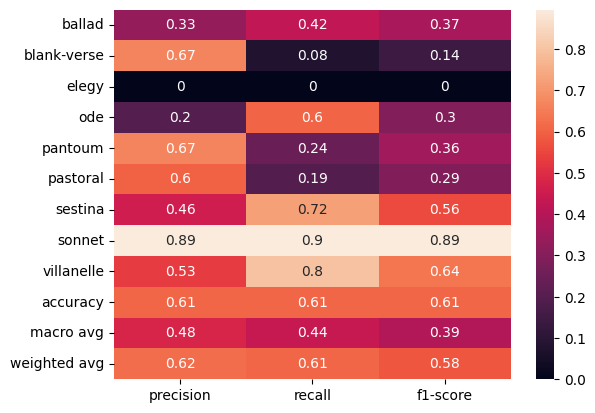

In [42]:
predictions = ALBERTiLSTM_model.predict([alberti_test_encodings.input_ids, alberti_test_encodings.token_type_ids, alberti_test_encodings.attention_mask, syllable_features_test])
ALBERTiLSTM_model_preds = tf.argmax(predictions, axis=-1)
class_report = sk_classification_report(y_test, ALBERTiLSTM_model_preds.numpy(), zero_division=0, target_names=le.classes_, output_dict=True)
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True)

Text(220.72222222222223, 0.5, 'True')

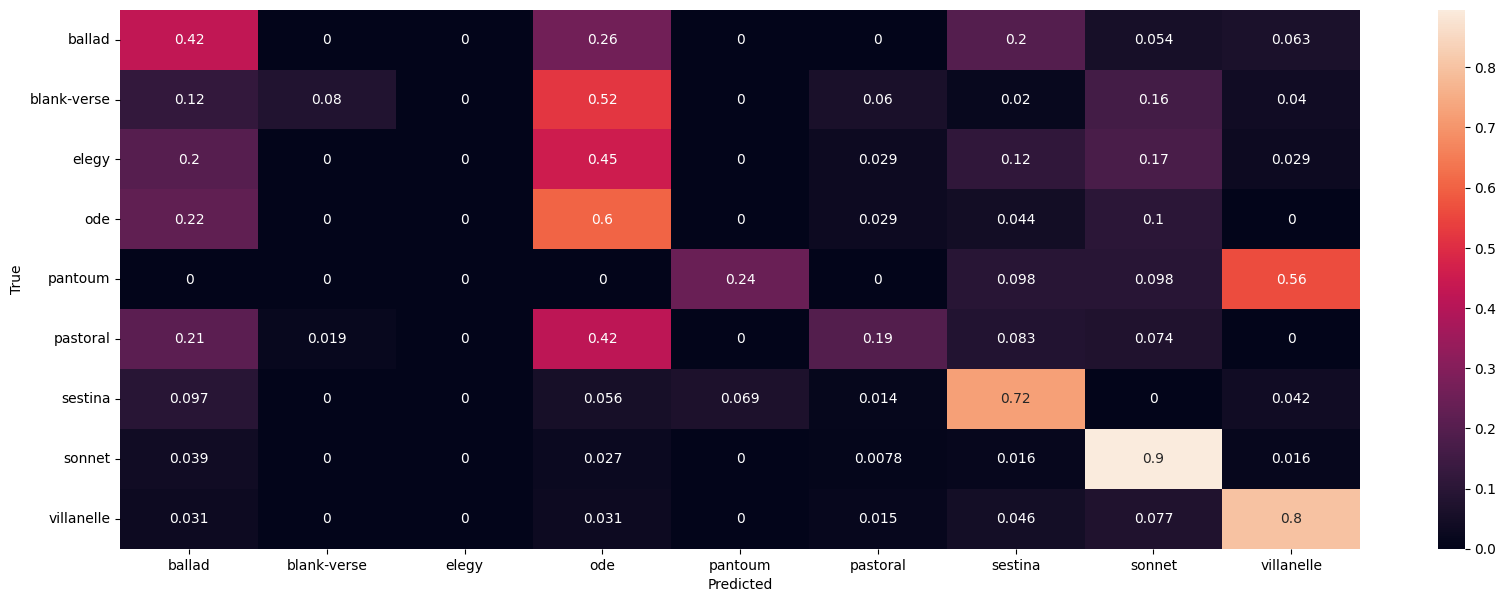

In [43]:
# Create confusion matrix
conf_matrix = tf.math.confusion_matrix(y_test, ALBERTiLSTM_model_preds)
conf_matrix = conf_matrix/conf_matrix.numpy().sum(axis=1)[:, tf.newaxis]

# Visualize confusion matrix
plt.figure(figsize=(20,7))
sns.heatmap(
    conf_matrix, annot=True,
    xticklabels=le.classes_,
    yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")


Epoch 1/5
86/86 [==============================] - 50s 588ms/step - loss: 1.4233 - accuracy: 0.5844 - precision_8: 0.8610 - recall_8: 0.4001 - val_loss: 1.0799 - val_accuracy: 0.6308 - val_precision_8: 0.8156 - val_recall_8: 0.5145
Epoch 2/5
86/86 [==============================] - 50s 588ms/step - loss: 1.1691 - accuracy: 0.6828 - precision_8: 0.8731 - recall_8: 0.5352 - val_loss: 1.0459 - val_accuracy: 0.6714 - val_precision_8: 0.8324 - val_recall_8: 0.5427
Epoch 3/5
86/86 [==============================] - 50s 588ms/step - loss: 0.9547 - accuracy: 0.7349 - precision_8: 0.8763 - recall_8: 0.6395 - val_loss: 0.9412 - val_accuracy: 0.6899 - val_precision_8: 0.8555 - val_recall_8: 0.5789
Epoch 4/5
86/86 [==============================] - 50s 587ms/step - loss: 0.7240 - accuracy: 0.7952 - precision_8: 0.8920 - recall_8: 0.7335 - val_loss: 0.8589 - val_accuracy: 0.7471 - val_precision_8: 0.8400 - val_recall_8: 0.6617
Epoch 5/5
36/36 [==============================] - 10s 277ms/step


<Axes: >

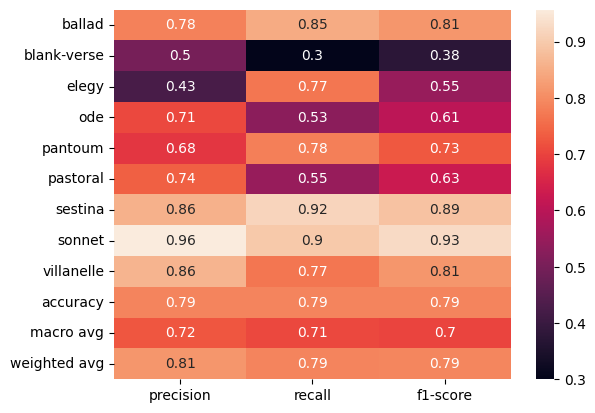

In [44]:
ALBERTiLSTM_model_history = ALBERTiLSTM_model.fit([alberti_train_encodings.input_ids, alberti_train_encodings.token_type_ids, alberti_train_encodings.attention_mask, syllable_features_train],
                                      train_labels,
                                      validation_data=([alberti_val_encodings.input_ids, alberti_val_encodings.token_type_ids, alberti_val_encodings.attention_mask, syllable_features_val], val_labels),
                                      batch_size=16,
                                      epochs=5,
                                      class_weight=CLASS_WEIGHTS)
score = ALBERTiLSTM_model.evaluate([alberti_test_encodings.input_ids, alberti_test_encodings.token_type_ids, alberti_test_encodings.attention_mask, syllable_features_test],
                                test_labels)


predictions = ALBERTiLSTM_model.predict([alberti_test_encodings.input_ids, alberti_test_encodings.token_type_ids, alberti_test_encodings.attention_mask, syllable_features_test])
ALBERTiLSTM_model_preds = tf.argmax(predictions, axis=-1)
class_report = sk_classification_report(y_test, ALBERTiLSTM_model_preds.numpy(), zero_division=0, target_names=le.classes_, output_dict=True)
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True)

Text(220.72222222222223, 0.5, 'True')

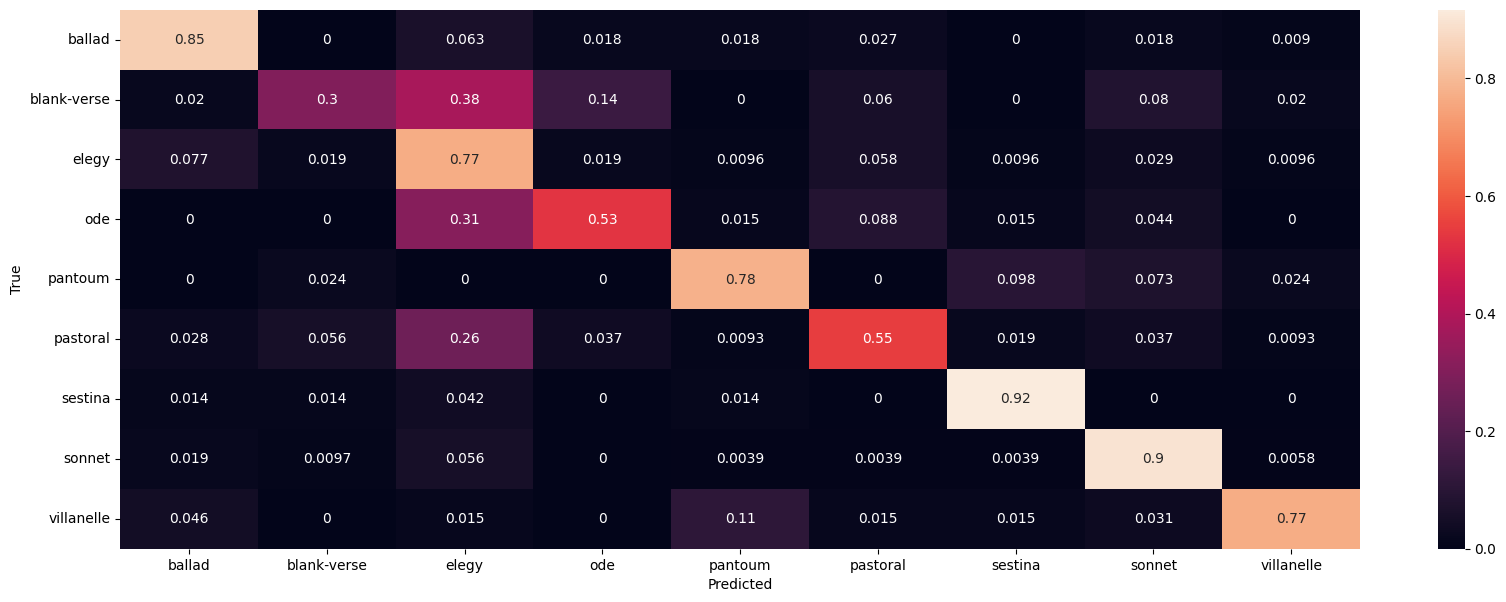

In [45]:
# Create confusion matrix
conf_matrix = tf.math.confusion_matrix(y_test, ALBERTiLSTM_model_preds)
conf_matrix = conf_matrix/conf_matrix.numpy().sum(axis=1)[:, tf.newaxis]

# Visualize confusion matrix
plt.figure(figsize=(20,7))
sns.heatmap(
    conf_matrix, annot=True,
    xticklabels=le.classes_,
    yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")


/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_pytorch_utils.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_state_dict = torch.load(pt_path, map_

Epoch 1/10


86/86 [==============================] - 93s 632ms/step - loss: 2.1145 - accuracy: 0.2430 - precision_10: 0.2857 - recall_10: 0.0015 - val_loss: 1.7010 - val_accuracy: 0.5480 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 2/10
86/86 [==============================] - 50s 588ms/step - loss: 1.7729 - accuracy: 0.4956 - precision_10: 0.7395 - recall_10: 0.0646 - val_loss: 1.3871 - val_accuracy: 0.5762 - val_precision_10: 0.8763 - val_recall_10: 0.2185
Epoch 3/10
86/86 [==============================] - 50s 587ms/step - loss: 1.5167 - accuracy: 0.5822 - precision_10: 0.8320 - recall_10: 0.2327 - val_loss: 1.3421 - val_accuracy: 0.5665 - val_precision_10: 0.7830 - val_recall_10: 0.3242
Epoch 4/10
86/86 [==============================] - 50s 587ms/step - loss: 1.3251 - accuracy: 0.6160 - precision_10: 0.7897 - recall_10: 0.3502 - val_loss: 1.1572 - val_accuracy: 0.6485 - val_precision_10: 0.8803 - val_recall_10: 0.3824
Epoch 5/10
86/86 [==============================] - 50s

<Axes: >

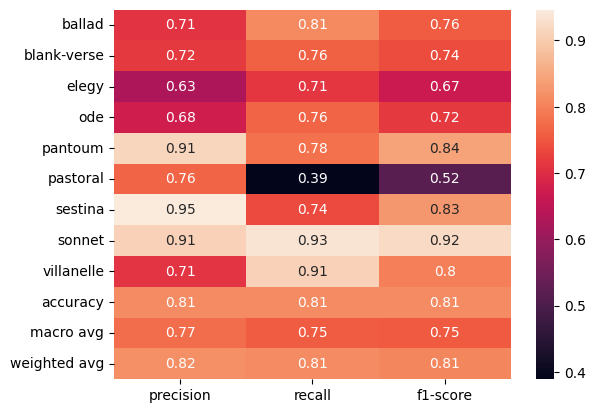

In [48]:
ALBERTiLSTM_model = create_alberti_model(model_checkpoint2, learning_rate=0.00001, dropout=0.5) #Decrease learning rate and increase dropout to account for overfitting
ALBERTiLSTM_model_history = ALBERTiLSTM_model.fit([alberti_train_encodings.input_ids, alberti_train_encodings.token_type_ids, alberti_train_encodings.attention_mask, syllable_features_train],
                                      train_labels,
                                      validation_data=([alberti_val_encodings.input_ids, alberti_val_encodings.token_type_ids, alberti_val_encodings.attention_mask, syllable_features_val], val_labels),
                                      batch_size=16,
                                      epochs=10,
                                      class_weight=CLASS_WEIGHTS)
score = ALBERTiLSTM_model.evaluate([alberti_test_encodings.input_ids, alberti_test_encodings.token_type_ids, alberti_test_encodings.attention_mask, syllable_features_test],
                                test_labels)


predictions = ALBERTiLSTM_model.predict([alberti_test_encodings.input_ids, alberti_test_encodings.token_type_ids, alberti_test_encodings.attention_mask, syllable_features_test])
ALBERTiLSTM_model_preds = tf.argmax(predictions, axis=-1)
class_report = sk_classification_report(y_test, ALBERTiLSTM_model_preds.numpy(), zero_division=0, target_names=le.classes_, output_dict=True)
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True)

Text(220.72222222222223, 0.5, 'True')

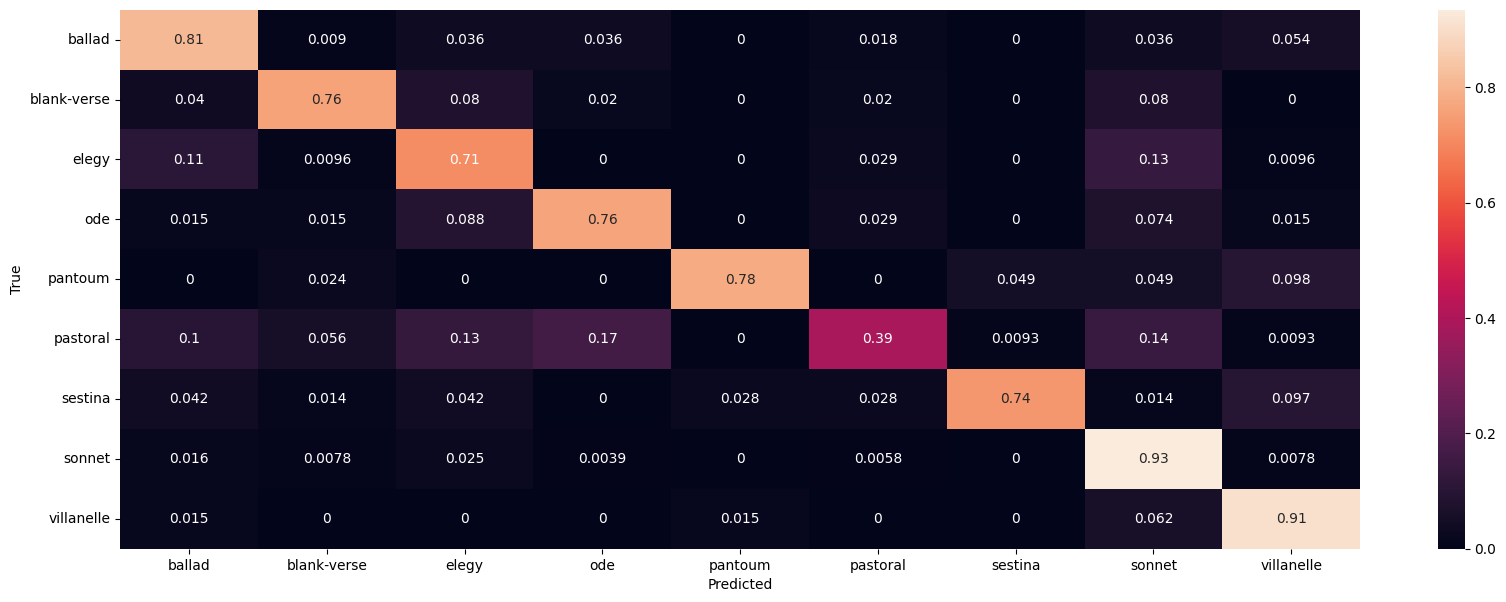

In [49]:
# Create confusion matrix
conf_matrix = tf.math.confusion_matrix(y_test, ALBERTiLSTM_model_preds)
conf_matrix = conf_matrix/conf_matrix.numpy().sum(axis=1)[:, tf.newaxis]

# Visualize confusion matrix
plt.figure(figsize=(20,7))
sns.heatmap(
    conf_matrix, annot=True,
    xticklabels=le.classes_,
    yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
